In [74]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Dense, MaxPooling2D, GlobalMaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

In [75]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

In [76]:
# train_path = '/content/drive/MyDrive/Colab Notebooks/brain_tumor_detection/brain_tumor_dataset/Training'
# test_path = '/content/drive/MyDrive/Colab Notebooks/brain_tumor_detection/brain_tumor_dataset/Testing'
train_path = 'brain_tumor_dataset/Training_balanced'
test_path = 'brain_tumor_dataset/Testing_balanced'

In [77]:
train_df = train_df(train_path)
test_df = test_df(test_path)
valid_df, test_df = train_test_split(test_df, train_size=0.5, random_state=20, stratify=test_df['Class'])
valid_df

,Class Path,Class
1116,brain_tumor_dataset/Testing_balanced/meningiom...,meningioma
917,brain_tumor_dataset/Testing_balanced/meningiom...,meningioma
195,brain_tumor_dataset/Testing_balanced/pituitary...,pituitary
455,brain_tumor_dataset/Testing_balanced/notumor/T...,notumor
861,brain_tumor_dataset/Testing_balanced/glioma/Te...,glioma
...,...,...
121,brain_tumor_dataset/Testing_balanced/pituitary...,pituitary
118,brain_tumor_dataset/Testing_balanced/pituitary...,pituitary
415,brain_tumor_dataset/Testing_balanced/notumor/T...,notumor
341,brain_tumor_dataset/Testing_balanced/notumor/T...,notumor


In [78]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 256
img_size = (224, 224)

_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=1/255)


train_gen = _gen.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = test_gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

test_gen = test_gen.flow_from_dataframe(test_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5284 validated image filenames belonging to 4 classes.
Found 600 validated image filenames belonging to 4 classes.
Found 600 validated image filenames belonging to 4 classes.


In [79]:
print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {test_gen.samples}")
print(f"Validation samples: {valid_gen.samples}")

Training samples: 5284
Validation samples: 600
Validation samples: 600


In [80]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

EPOCHS = 10
checkpoint_filepath = './ckpt/checkpoint.model.keras'
model_temp = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_temp.trainable = False

model = Sequential()
model.add(model_temp)
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Flatten())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())

# Add additional layers
# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())

# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())

# model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax'))
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model.summary()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 3, 3, 960)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8640)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     2,212,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,277,316 (20.13 MB)

 Trainable params: 2,279,940 (8.70 MB)

 Non-trainable params: 2,997,376 (11.43 MB)

Num GPUs Available:  1


In [81]:
import time
start_time = time.time()

history = model.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    callbacks=[lr_scheduler, model_checkpoint_callback]
)

end_time = time.time()

print('The training of the Transfer Learning model took',round((end_time-start_time)/60),'minutes.')

/Users/gary/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.4072 - loss: 1.5831 - val_accuracy: 0.3500 - val_loss: 9.2524 - learning_rate: 0.0100
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5378 - loss: 1.0399 - val_accuracy: 0.3767 - val_loss: 7.2951 - learning_rate: 0.0100
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5804 - loss: 0.9732 - val_accuracy: 0.3667 - val_loss: 8.4371 - learning_rate: 0.0100
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5901 - loss: 0.9828 - val_accuracy: 0.3600 - val_loss: 7.2977 - learning_rate: 0.0100
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6177 - loss: 0.9058 - val_accuracy: 0.4200 - val_loss: 3.1555 - learning_rate: 0.0100
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6371 - loss: 0.8583 - val_accuracy: 0.6200 - val_loss: 1.1058 - learning_rate: 0.0100
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6374 - loss: 0.8666 - val_accuracy: 

In [88]:
# val_loss, val_accuracy = model.evaluate(x_test, y_test)
best_model = tf.keras.models.load_model('ckpt/checkpoint.model.keras')
test_loss, test_accuracy = best_model.evaluate(
    test_gen,
)

print(f"Test Loss: {round(test_loss,4)}")
print(f"Test Accuracy: {round(100*test_accuracy,2)}%")


38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 428ms/step - accuracy: 0.7601 - loss: 0.6082
Test Loss: 0.6608
Test Accuracy: 74.5%


In [83]:
print(history.history)

{'accuracy': [0.46309614181518555, 0.5490158796310425, 0.5880014896392822, 0.60370934009552, 0.6144965887069702, 0.6356926560401917, 0.6417486667633057, 0.6491294503211975, 0.6669189929962158, 0.663133978843689, 0.658024251461029, 0.6693792343139648, 0.6633232235908508, 0.6778955459594727, 0.6722180247306824, 0.6907645463943481, 0.6847085356712341, 0.6831945776939392, 0.6871688365936279, 0.6850870847702026, 0.694549560546875, 0.6936033368110657, 0.7057153582572937, 0.6886827945709229, 0.7040120959281921, 0.7055261135101318, 0.7000378370285034, 0.7087433934211731, 0.713853120803833, 0.7079863548278809, 0.7057153582572937, 0.7108251452445984, 0.7066616415977478, 0.7024980783462524, 0.7161241769790649, 0.717448890209198, 0.7161241769790649, 0.7180166244506836, 0.7151778936386108, 0.724640429019928, 0.7214231491088867, 0.7117713689804077, 0.7146101593971252, 0.7219909429550171, 0.708932638168335, 0.7117713689804077, 0.7159348726272583, 0.7193413972854614, 0.7219909429550171, 0.711392879486

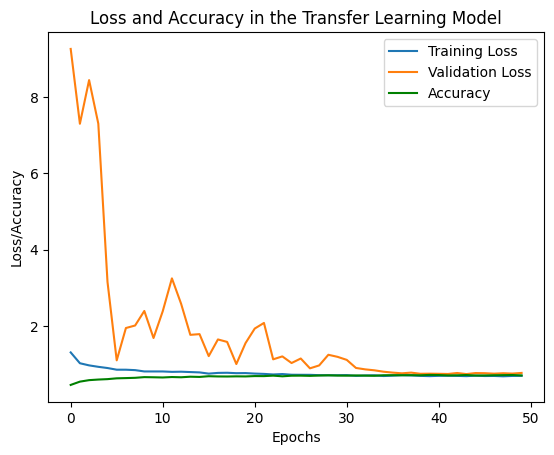

In [84]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history["accuracy"],label='Accuracy' ,c="green")
plt.title("Loss and Accuracy in the Transfer Learning Model")
plt.ylabel("Loss/Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()


In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_labels = np.argmax(best_model.predict(test_gen),axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 711ms/step


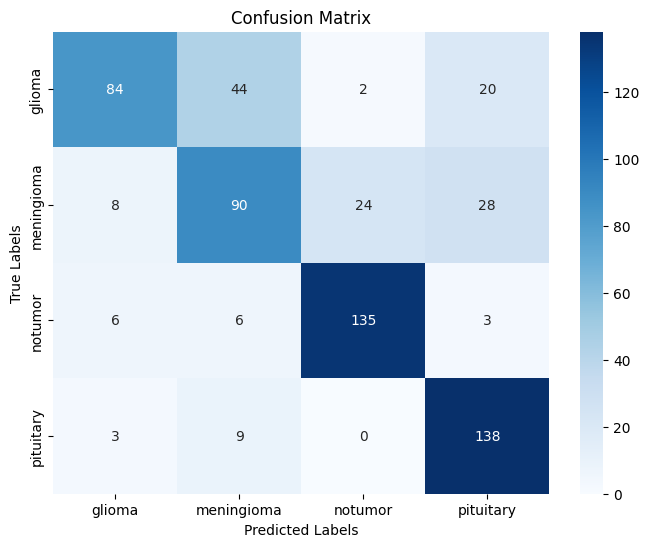

In [90]:
import seaborn as sns

true_labels = test_gen.classes

cm = confusion_matrix(true_labels, predicted_labels)

# Step 4: Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
